In [99]:
import math
import requests
import json

# Define the coordinate to check
y = 51.855422
x = 4.967723

################################## GET ENVIROMENT TYPE ###################################
# Build the OSM API query URL
url = 'https://nominatim.openstreetmap.org/reverse?format=json&lat={}&lon={}&zoom=18&addressdetails=1'.format(y, x)

# Send a GET request to the API and get the response
response = requests.get(url)

# Parse the response JSON data
data = json.loads(response.content)

# Check type
if 'city' in data['address']:
    print('The coordinates are in the city of', data['address']['city'])
    enviroment = "city"
elif 'village' in data['address']:
    print('The coordinates are in the village of', data['address']['village'])
    enviroment = "village"
else:
    print('The coordinates are in the plains.')
    enviroment = "plains"

################################# GET FLOOD DEPTHS #########################################
# Define the bounding box in EPSG:4326 (WGS84) coordinates as [min_lon, min_lat, max_lon, max_lat]
x1 = x + 0.0001
y1 = y + 0.0001
bbox = [y, x, y1, x1]

# Convert the bbox list to a string
bbox_str = ','.join(str(coord) for coord in bbox)

# Define the common URL parameters
params = {
    "SERVICE": "WMS",
    "VERSION": "1.3.0",
    "REQUEST": "GetFeatureInfo",
    "FORMAT": "image/png",
    "TRANSPARENT": "true",
    "INFO_FORMAT": "application/json",
    "FEATURE_COUNT": "8",
    "I": "50",
    "J": "50",
    "CRS": "EPSG:4326",
    "STYLES": "",
    "WIDTH": "101",
    "HEIGHT": "101",
    "BBOX": bbox_str,
    "x": x,
    "y": y,
}

# Define a dictionary to store the responses
responses = {}

# Define a list of layers to query
layers = ["overstromingsdiepte_extreem_kleine_kans", "overstromingsdiepte_kleine_kans", "overstromingsdiepte_middelgrote_kans", "overstromingsdiepte_grote_kans"]

# Loop over the layers and make separate requests for each layer
for layer in layers:
    params["QUERY_LAYERS"] = layer
    params["LAYERS"] = layer
    
    # Construct the URL using string formatting
    url = "https://apps.geodan.nl/public/data/org/gws/YWFMLMWERURF/kea_public/wms?v1_0&" + "&".join("{}={}".format(k, v) for k, v in params.items())
    
    # Send the request and parse the JSON response
    response = requests.get(url)
    data = response.json()
    
    # Store the response in the dictionary
    responses[layer] = data

    # Extract the "properties" field from the response
    properties = data["features"][0]["properties"]
    
    # Get the "GRAY_INDEX" value and check if it's -9999
    gray_index = properties['GRAY_INDEX']
    if gray_index == -9999:
        gray_index = 0

    # Store the numerical value in the corresponding variable
    if layer == "overstromingsdiepte_extreem_kleine_kans":
        extreem_kleine_kans_val = gray_index
    elif layer == "overstromingsdiepte_kleine_kans":
        kleine_kans_val = gray_index
    elif layer == "overstromingsdiepte_middelgrote_kans":
        middelgrote_kans_val = gray_index
    elif layer == "overstromingsdiepte_grote_kans":
        grote_kans_val = gray_index

print(extreem_kleine_kans_val, kleine_kans_val, middelgrote_kans_val, grote_kans_val)

################################### GET COLUMN PROPERTIES ########################################
# Loaded info
connection = "fixed" # fixed or hinge
material = "wood"
Length = 6 # m
Height = 0.3 # m
Width = 0.3 # m
Thickness = 0.07 # m

########################## GET WATER TYPE AND FLOOD DEPTH + FLOOD RISK #########################
WaterType = "salt" # majority of seas and rivers in the netherlands are salty
# DesignStillwaterDepth = 3 # m

The coordinates are in the plains.
2.9375 2.9375 1.6265000104904175 0


In [100]:
################################### GET VALUES FROM GIVEN VARIABLES ################################
#  Modulus of elasticity in MPa
match material:
    # Source: https://www.calculand.com/unit-converter/stoffe-liste.php?gruppe=Elastic+modulus+%28E%29%2C+Young%27s+modulus&einheit=1e6--MPa
    case "concrete":
        Elasticity =  30 * 1000 * 1000000   # MPA concrete 
    case "wood":
        Elasticity =  11 * 1000 * 1000000  # MPA wood 
    case "steel":
        Elasticity =  200 * 1000 * 1000000  # MPA steel 

# Second moment of area in m4
match material:
    case "concrete":
        WidthMM = Width * 1000
        HeightMM = Height * 1000
        Inertia = (((WidthMM * (HeightMM**3))) / 12 ) * (10**-12)#
    case "wood":
        WidthMM = Width * 1000
        HeightMM = Height * 1000
        Inertia = (((WidthMM * (HeightMM**3))) / 12 ) * (10**-12)#
    case "steel":
        # Inertia = 14920 * 10**-8 # cm^4 to m4 steel HE 320A
        WidthMM = Width * 1000
        HeightMM = Height * 1000
        ThicknessMM = Thickness * 1000
        Inertia = (((ThicknessMM * (HeightMM**3)) / 12) + ((WidthMM / 12)* ((HeightMM**3)) - ((HeightMM**3)*(1/5))) * -1) * (10**-12)

# specific weights per water type
match WaterType:
    case "salt":
        SpecificWeightWater = 64.0 * 16.0185 # lb/ft3 to kg/m3
    case "fresh":
        SpecificWeightWater = 62.4 * 16.0185 # lb/ft3 to kg/m3

# Debris weight
match enviroment:
    case "city":
        DebrisWeight =  1500 # car weight
    case "village":
        DebrisWeight =  655 # tree weight https://www.researchgate.net/figure/Summary-of-tree-heights-weights-and-volumes_tbl1_232354725
    case "plains":
        DebrisWeight =  454 # wood weight

# t = duration of impact in seconds
match material:
# City of Honolulu building code for impact durations
    case "concrete":
        impacttime = 0.1 # second
    case "wood":
        impacttime = 1 # second 
    case "steel":
        impacttime = 0.5 # second

# Max deflection limits Column
match material:
     # Source: Eurocode 5, 3, 2 (in order)
    case "concrete":
        PermittedDeflection =  (Length * 1000) / 500 # EUC 5 Concrete
    case "wood":
        PermittedDeflection =  (Length * 1000) / 300 # EUC 3 wood 
    case "steel":
        PermittedDeflection =  (Length * 1000) / 500 # EUC 2 steel


In [101]:
# define the four different design stillwater depths
design_stillwater_depths = [extreem_kleine_kans_val, kleine_kans_val, middelgrote_kans_val, grote_kans_val]
loop = 0 
damagepercentagelist = []

# design_stillwater_depths = [1.5, 2.0, 2.5, 3.0]
for DesignStillwaterDepth in design_stillwater_depths:
    print(layers[loop])
    loop += 1 
    if DesignStillwaterDepth != 0:
        GravitationalConstant = 9.81 # m/s
        Velocity = (GravitationalConstant * DesignStillwaterDepth)**0.5 # V = (gds)0.5

        # Breaking wave calculation
        def breakingwave():
            DragCoefficient = 2.25 # if square
            HeightMetric = Height * 0.3048
            BreakingWaveOnPiles = 0.5 * DragCoefficient * SpecificWeightWater * HeightMetric * (DesignStillwaterDepth**2)
            return BreakingWaveOnPiles

        # Hydrostatic
        def hydrostatic():
            HydrostaticLoadPerWidth = 0.5 * SpecificWeightWater * (DesignStillwaterDepth**2) # kg
            HydrostaticLoad = HydrostaticLoadPerWidth * Width
            return HydrostaticLoad

        # Couldn't convert to metric, thus this function will be in imperial
        # Hydrodynamic (Fluid dynamics)
        def hydrodynamic():
            CrossArea = Height * Width
            DragCoefficient = 2 # square
            match WaterType:
                case "salt":
                    MassDensityFluid = 1.99  # slugs/ft3 
                case "fresh":
                    MassDensityFluid = 1.94  # slugs/ft3 
            VelocityImp = Velocity * 3.2808399
            CrossAreaImp = CrossArea * 10.7639
            HydrodynamicLoad = 0.5 * DragCoefficient * MassDensityFluid * (VelocityImp**2) * CrossAreaImp
            # HydrodynamicLoad = HydrodynamicLoad * 0.453592
            return HydrodynamicLoad

        def debrisimpact():
            DebrisLoad = (DebrisWeight * Velocity) / (GravitationalConstant * impacttime)
            return DebrisLoad

        # Calculate all necessary loads
        BreakingWaves = breakingwave()
        HydrodynamicLoad = hydrodynamic()
        HydrostaticLoad = hydrostatic()
        DebrisLoad = debrisimpact()

        print("For Design Stillwater Depth:", DesignStillwaterDepth)
        # print("breaking", BreakingWaves, "hydrodynamic", HydrodynamicLoad, "hydrostatic", HydrostaticLoad, "debris", DebrisLoad)

        # convert weight into forces
        LoadBreak = (BreakingWaves * GravitationalConstant) / 1000 # Fz (kN) = m*g / 1000 
        LoadCombination = ((HydrodynamicLoad + HydrostaticLoad) * GravitationalConstant) / 1000 # Fz (kN) = m*g / 1000 
        LoadDebris = (DebrisLoad * GravitationalConstant) / 1000 # Fz (kN) = m*g / 1000 

        print("breaking", LoadBreak, "kN", "hydrodynamic", LoadCombination, "kN", "Debris", LoadDebris, "kN")

        # Calculate reaction loads
        def reactionloads(Load):
            if connection == "fixed":
                ReactionloadR1 = ((Load * (DesignStillwaterDepth * 1/3)**2) / (2* Length**3)) * ((DesignStillwaterDepth*2/3) + (2*Length))
                ReactionloadR2 = ((Load * (DesignStillwaterDepth * 2/3)) / (2* (Length**3))) * ((3 * (Length**2)) - ((DesignStillwaterDepth*2/3)**2))
            elif connection == "hinge":    
                ReactionloadR1 = (Load * (DesignStillwaterDepth * 2/3))/2
                ReactionloadR2 = (Load * (DesignStillwaterDepth * 1/3))/2
            return ReactionloadR1, ReactionloadR2

        # ReactionLoadsBreak = reactionloads(LoadBreak)
        # print("Breaking Wave:", "R1", ReactionLoadsBreak[0], "kN", "R2", ReactionLoadsBreak[1], "kN")

        # ReactionLoadsComb = reactionloads(LoadCombination)
        # print("Hydrostatic and Hydrodynamic:", "R1", ReactionLoadsComb[0], "kN", "R2", ReactionLoadsComb[1], "kN")

        # ReactionLoadsDebris = reactionloads(LoadDebris)
        # print("Debris Load:", "R1", ReactionLoadsComb[0], "kN", "R2", ReactionLoadsComb[1], "kN")

        # Calculate moments for breaking loads and load combinations
        def moments(Load, ReactionLoads):
            # formulas from structx
            if connection == "fixed":
                MomentLoad = ReactionLoads[0] * (DesignStillwaterDepth * 2/3)
                MomentFixed = ((Load * (DesignStillwaterDepth * 2/3) * (DesignStillwaterDepth * 1/3)) / (2 * (Length**2))) * ((DesignStillwaterDepth * 2/3) + Length)
            elif connection == "hinge":    
                MomentLoad = (Load * (DesignStillwaterDepth * 2/3) * (DesignStillwaterDepth * 1/3)) / Length
                MomentFixed = None
            return MomentLoad, MomentFixed

        # MomentLoadsBreak = moments(LoadBreak, ReactionLoadsBreak)
        # print("Breaking Wave:", "M1", round(MomentLoadsBreak[0], 3), "kN", "M2", round(MomentLoadsBreak[1], 3), "kN")

        # MomentLoadsCombination = moments(LoadCombination, ReactionLoadsComb)
        # print("Hydrostatic and Hydrodynamic:", "M1", MomentLoadsCombination[0], "kN", "M2", MomentLoadsCombination[1], "kN")

        # MomentLoadsDebris = moments(LoadDebris, ReactionLoadsDebris)
        # print("Debris impact:", "M1", MomentLoadsDebris[0], "kN", "M2", MomentLoadsDebris[1], "kN")

        # calculate max deflection for both breaking loads and the load combination
        def deflection(Load):
            # formula from https://structx.com/Beam_Formulas_014.html
            if connection == "fixed":
                MaxDeflection = ((Load * ((DesignStillwaterDepth * 2/3) ** 3) * ((DesignStillwaterDepth * 1/3) ** 2)) / (12 * Elasticity * Inertia * (Length ** 3))) * ((3 * Length) + (DesignStillwaterDepth * 1/3))
            # formula from https://structx.com/Beam_Formulas_008.html
            elif connection == "hinge":
                MaxDeflection = (Load * ((DesignStillwaterDepth * 1/3) ** 2) * ((DesignStillwaterDepth * 2/3) ** 2)) / (3 * Elasticity * Inertia * Length)
            return MaxDeflection
            

        MaxdefBreak = deflection(LoadBreak) 
        MaxdefCombination = deflection(LoadCombination) 
        MaxdefDebris = deflection(LoadDebris) 

        # check if max deflection exceeds permitted deflection
        def delfectioncheck(MaxDeflection):
            if (MaxDeflection * 1000) > PermittedDeflection:
                print("Deflection: Risk detected", "permitted amount is", round(PermittedDeflection, 3), "mm occuring amount is", round(MaxDeflection * 1000, 3), "mm")
                probability = False
            else:
                print("Deflection: Column is OK", "permitted amount is", round(PermittedDeflection, 3), "mm occuring amount is", round(MaxDeflection * 1000, 3), "mm")
                probability = True
            return probability 

        FloodProbabilitySum = 0

        deflection_checks = [("Breaking Loads", MaxdefBreak * 1000), ("Hydrostatic and Hydrodynamic Loads", MaxdefCombination * 1000), ("Debris Loads", MaxdefDebris * 1000)]

        FloodProbabilityList = []

        for load_type, max_deflection in deflection_checks:
            if not delfectioncheck(max_deflection):
                FloodProbabilityList.append(1)
            else:
                FloodProbabilityList.append(0)

        print(FloodProbabilityList)
        
        if sum(FloodProbabilityList) == 0:
            Damagepercentage = 0
            damagepercentagelist.append(Damagepercentage)
        else:
            Damagepercentage = (0.13 * math.sqrt(DesignStillwaterDepth))
            damagepercentagelist.append(Damagepercentage)

    else: 
        print("This location has no determined risk for flooding by Klimapedia")
        Damagepercentage = 0

        damagepercentagelist.append(Damagepercentage)

print(damagepercentagelist)

overstromingsdiepte_extreem_kleine_kans
For Design Stillwater Depth: 2.9375
breaking 8.927201084336888 kN hydrodynamic 18.883331321403592 kN Debris 2.4371333585792962 kN
Deflection: Column is OK permitted amount is 20.0 mm occuring amount is 0.063 mm
Deflection: Column is OK permitted amount is 20.0 mm occuring amount is 0.134 mm
Deflection: Column is OK permitted amount is 20.0 mm occuring amount is 0.017 mm
[0, 0, 0]
overstromingsdiepte_kleine_kans
For Design Stillwater Depth: 2.9375
breaking 8.927201084336888 kN hydrodynamic 18.883331321403592 kN Debris 2.4371333585792962 kN
Deflection: Column is OK permitted amount is 20.0 mm occuring amount is 0.063 mm
Deflection: Column is OK permitted amount is 20.0 mm occuring amount is 0.134 mm
Deflection: Column is OK permitted amount is 20.0 mm occuring amount is 0.017 mm
[0, 0, 0]
overstromingsdiepte_middelgrote_kans
For Design Stillwater Depth: 1.6265000104904175
breaking 2.73695531915871 kN hydrodynamic 7.238979427954609 kN Debris 1.81349

[1.0, 1.0, 1.0, 1.0]


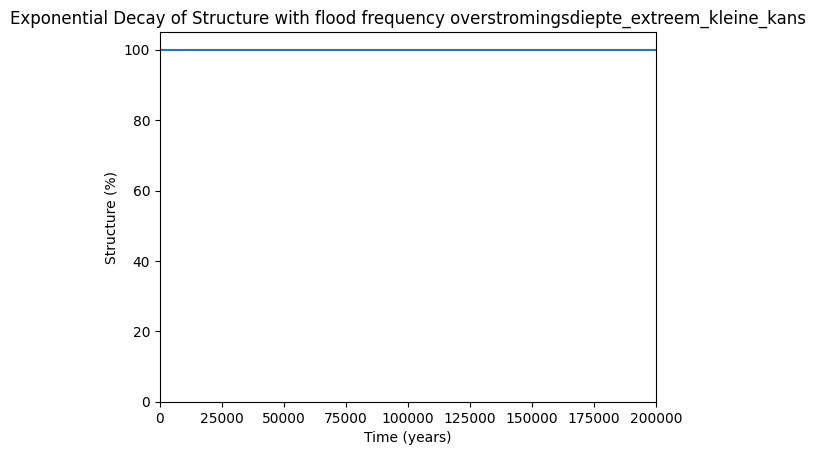

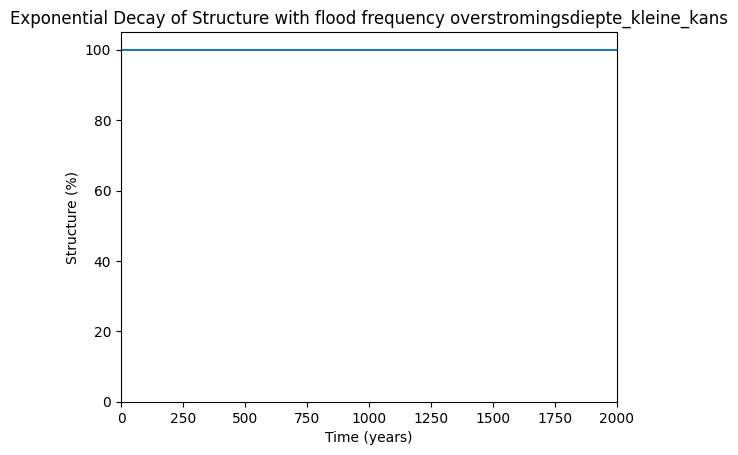

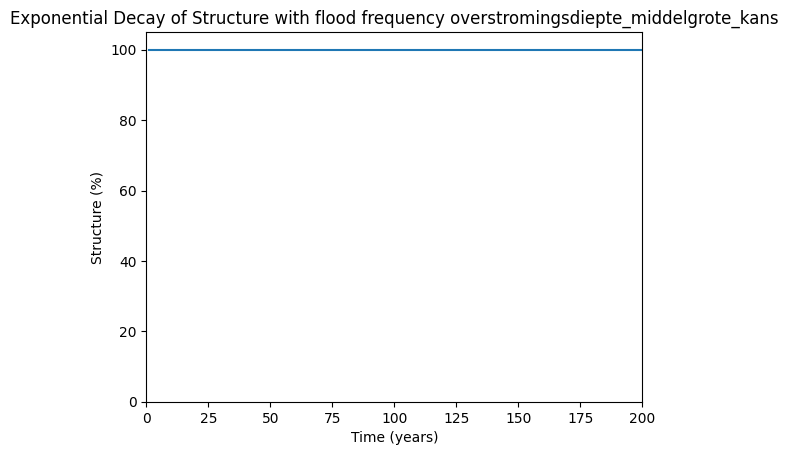

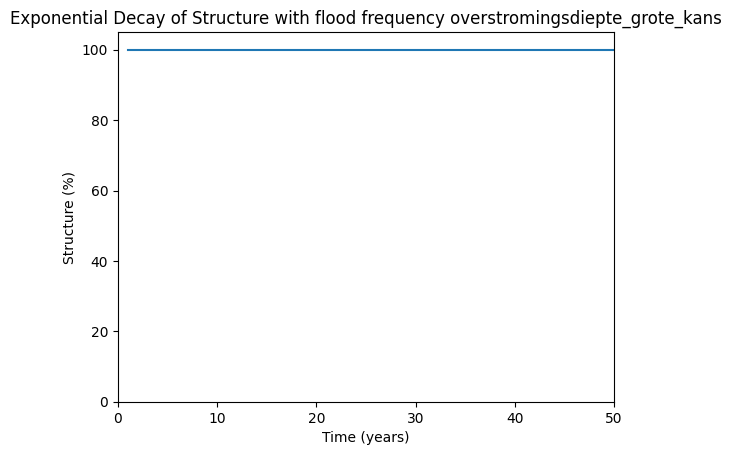

In [102]:
import matplotlib.pyplot as plt
import numpy as np

layers = ["overstromingsdiepte_extreem_kleine_kans", "overstromingsdiepte_kleine_kans", "overstromingsdiepte_middelgrote_kans", "overstromingsdiepte_grote_kans"]

damagepercentagelist
factoroflossstructural = []
index = [0, 1, 2, 3] # amount of scenarios

for i in index:
    factor = (100 - (100 * damagepercentagelist[i])) / 100
    factoroflossstructural.append(factor)

print (factoroflossstructural)

frequency = [100000, 1000, 100, 10] # overstromingsdiepte_extreem_kleine_kans = 1 in 100000, overstromingsdiepte_kleine_kans = 1 in 1000, overstromingsdiepte_middelgrote_kans = 1 in 100, overstromingsdiepte_grote_kans = 1 in 10
scales = [200000, 2000, 200, 50]
loop = 0

for i in index:
    # Define the formula for y
    x = np.array([1, 10, 30, 50, 100, 1000, 100000, 200000])
    y = 100 * (factoroflossstructural[i])**(np.floor(x/frequency[i]))

    # Plot the graph
    plt.plot(x, y)
    plt.title("Exponential Decay of Structure with flood frequency " +  layers[loop])
    plt.xlabel("Time (years)")
    plt.ylabel("Structure (%)")
    plt.ylim(0, 105) 
    plt.xlim(0, scales[i])
    plt.show()

    loop += 1


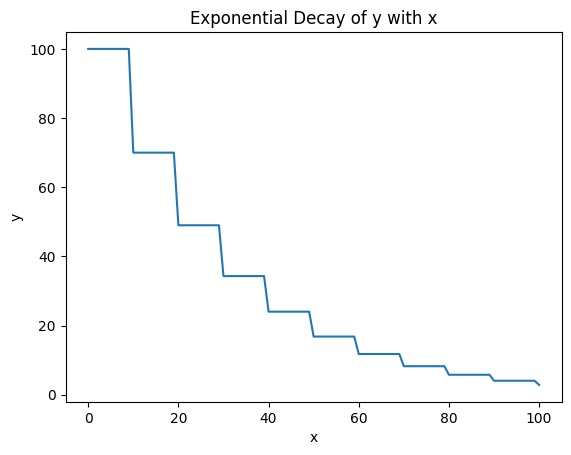

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Define the formula for y
def y(x):
    return 100 * (0.7)**(np.floor(x/10))

# Generate values of x
x = np.arange(0, 101, 1)

# Generate values of y using the formula
y_values = y(x)

# Plot the graph
plt.plot(x, y_values)
plt.title("Exponential Decay of y with x")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

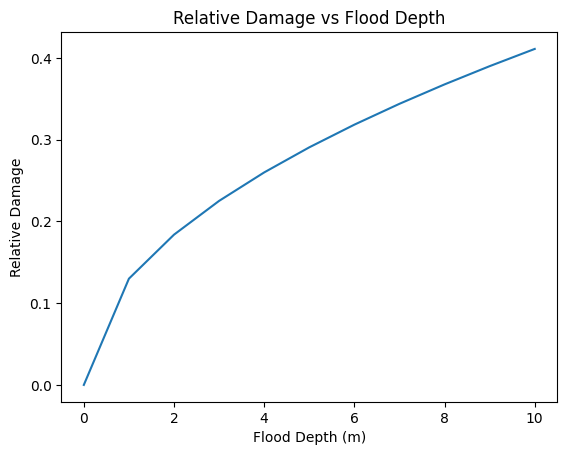

In [3]:
# https://nhess.copernicus.org/articles/19/661/2019/

import math
import matplotlib.pyplot as plt

# Input data
Flooddepth = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Calculate the mass loss rate using the Arrhenius equation
Relativedamage = []
for F in Flooddepth:
    Relativedamage.append(0.13 * math.sqrt(F))

# Plot the mass loss rate over flood depth
plt.plot(Flooddepth, Relativedamage)
plt.xlabel('Flood Depth (m)')
plt.ylabel('Relative Damage')
plt.title('Relative Damage vs Flood Depth')
plt.show()
